
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20.1?urlpath=lab/tree/tutorials/data/hess.ipynb)
- You may download all the notebooks as a [tar file](../../_downloads/notebooks-0.20.1.tar).
- **Source files:**
[hess.ipynb](../../_static/notebooks/hess.ipynb) |
[hess.py](../../_static/notebooks/hess.py)
</div>


# H.E.S.S. with Gammapy

[H.E.S.S.](https://www.mpi-hd.mpg.de/hfm/HESS/) is an array of gamma-ray telescopes located in Namibia. Gammapy is regularly used and fully supports H.E.S.S. high level data analysis, after export to the current [open data level 3 format](https://gamma-astro-data-formats.readthedocs.io/).

The H.E.S.S. data is private, and H.E.S.S. analysis is mostly documented and discussed at https://hess-confluence.desy.de/ and in H.E.S.S.-internal communication channels. However, in 2018, a small sub-set of archival H.E.S.S. data was publicly released, called the [H.E.S.S. DL3 DR1](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/), the data level 3, data release number 1. This dataset is 50 MB in size and is used in many Gammapy analysis tutorials, and can be downloaded via [gammapy download](https://docs.gammapy.org/dev/getting-started/index.html#quickstart-setup).

This notebook is a quick introduction to this specific DR1 release. It briefly describes H.E.S.S. data and instrument responses and show a simple exploration of the data with the creation of theta-squared plot.

H.E.S.S. members can find details on the DL3 FITS production on this [Confluence page](https://hess-confluence.desy.de/confluence/display/HESS/HESS+FITS+data) and access more detailed tutorials in this [repository](https://bitbucket.org/hess_software/hess-open-source-tools/src/master/)  

## DL3 DR1

This is how to access data and IRFs from the H.E.S.S. data level 3, data release 1.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker
from gammapy.makers.utils import make_theta_squared_table
from gammapy.visualization import plot_theta_squared_table

A useful way to organize the relevant files are the index tables. The observation index table contains information on each particular run, such as the pointing, or the run ID. The HDU index table has a row per relevant file (i.e., events, effective area, psf...) and contains the path to said file. Together they can be loaded into a Datastore by indicating the directory in which they can be found, in this case "$GAMMAPY_DATA/hess-dl3-dr1":

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [4]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /Users/terrier/Code/gammapy-dev/gammapy-data/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [5]:
data_store.obs_table[:2][["OBS_ID", "DATE-OBS", "RA_PNT", "DEC_PNT", "OBJECT"]]

OBS_ID,DATE-OBS,RA_PNT,DEC_PNT,OBJECT
,,deg,deg,
int64,bytes10,float32,float32,bytes18
20136,2004-03-26,228.6125,-58.771667,MSH15-52
20137,2004-03-26,228.6125,-59.771667,MSH15-52


In [6]:
obs = data_store.obs(23523)

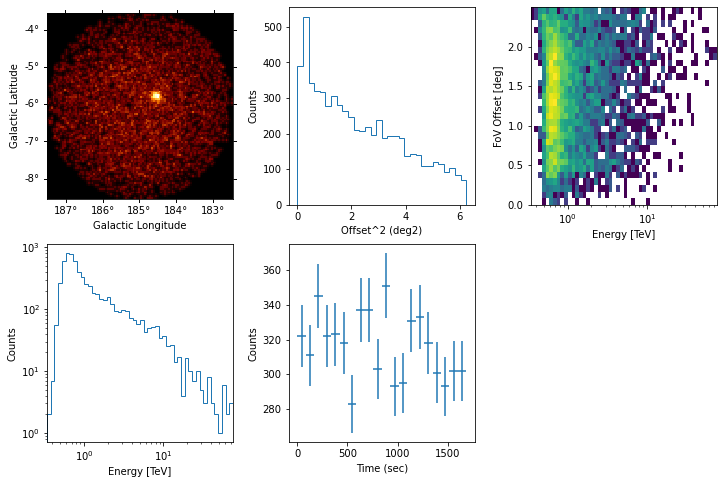

In [7]:
obs.events.select_offset([0, 2.5] * u.deg).peek()

/Users/terrier/Code/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


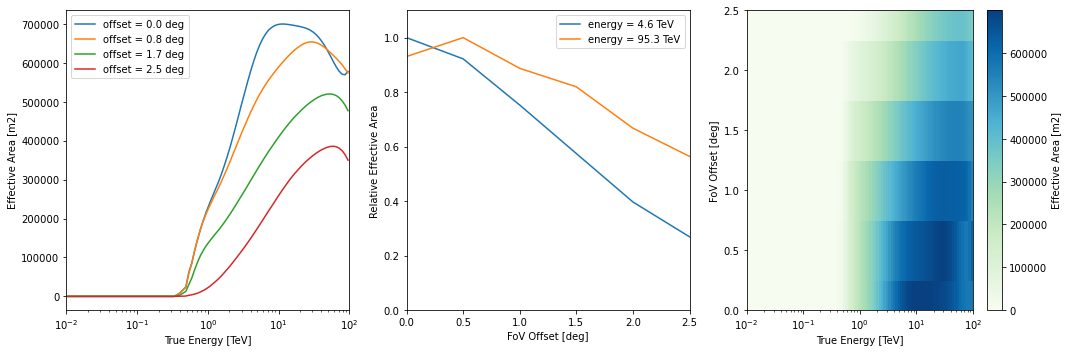

In [8]:
obs.aeff.peek()

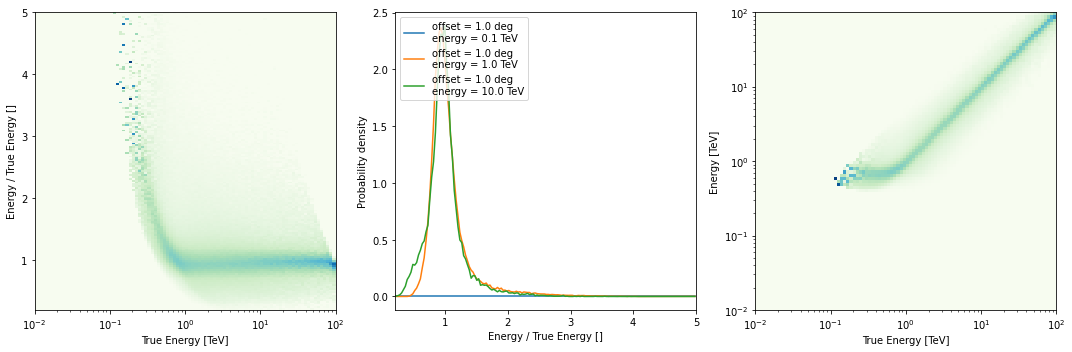

In [9]:
obs.edisp.peek()

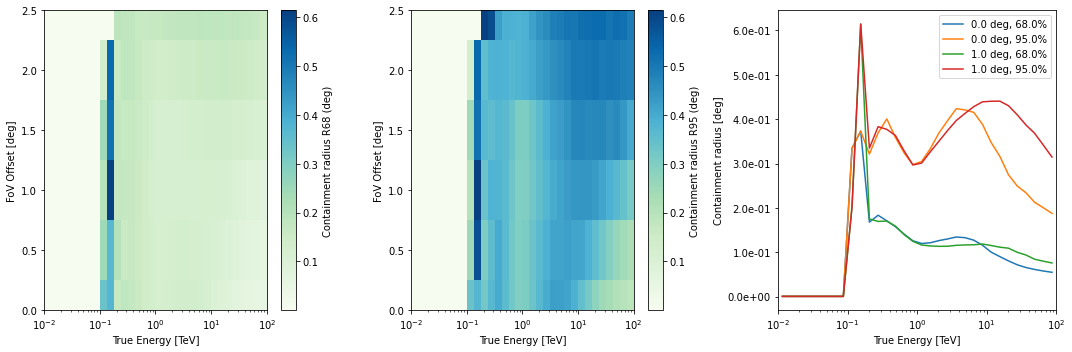

In [10]:
obs.psf.peek()

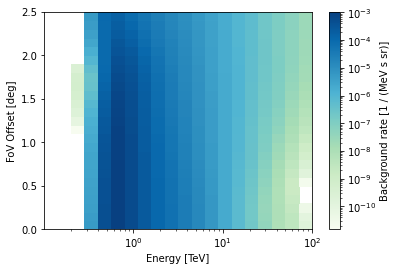

In [11]:
obs.bkg.to_2d().plot()

## Theta squared event distribution
As a quick look plot it can be helpful to plot the quadratic offset (theta squared) distribution of the events. 

In [12]:
position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
theta2_axis = MapAxis.from_bounds(0, 0.2, nbin=20, interp="lin", unit="deg2")

observations = data_store.get_observations([23523, 23526])
theta2_table = make_theta_squared_table(
    observations=observations,
    position=position,
    theta_squared_axis=theta2_axis,
)

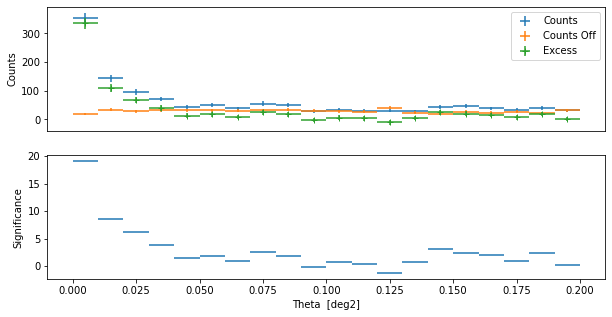

In [13]:
plt.figure(figsize=(10, 5))
plot_theta_squared_table(theta2_table)

## On-axis equivalent livetime

Since the acceptance of the H.E.S.S. camera varies within the field of view, what is often interesting is not the simply the total number of hours a source was observed, but the on-axis equivalent number of hours. We calculated the same for the MSH 1552 runs here.

In [14]:
# Get the observations
obs_id = data_store.obs_table["OBS_ID"][
    data_store.obs_table["OBJECT"] == "MSH 15-5-02"
]
observations = data_store.get_observations(obs_id)
print(len(observations))

17


In [15]:
# Define an energy range
energy_min = 100 * u.GeV
energy_max = 10.0 * u.TeV

# define a offset cut
offset_max = 2.5 * u.deg

In [16]:
# define the geom
source_pos = SkyCoord(228.32, -59.08, unit="deg")
energy_axis_true = MapAxis.from_energy_bounds(
    energy_min, energy_max, nbin=1, name="energy_true"
)
geom = WcsGeom.create(
    skydir=source_pos,
    binsz=0.02,
    width=(6, 6),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis_true],
)

In [17]:
# compute
livetime = Map.from_geom(geom, unit=u.hr)
for obs in observations:
    geom_obs = geom.cutout(position=obs.pointing_radec, width=2.0 * offset_max)
    exposure = MapDatasetMaker.make_exposure(geom=geom_obs, observation=obs)
    on_axis = obs.aeff.evaluate(
        offset=0.0 * u.deg, energy_true=geom.axes["energy_true"].center
    )
    on_axis = on_axis.reshape((on_axis.shape[0], 1, 1))
    lv_obs = exposure / on_axis
    livetime.stack(lv_obs)

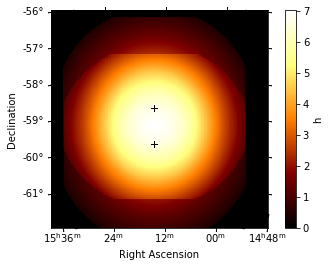

In [18]:
# Plot
ax = livetime.plot(add_cbar=True)

# Add the pointing position on top
for obs in observations:
    ax.plot(
        obs.pointing_radec.to_pixel(wcs=ax.wcs)[0],
        obs.pointing_radec.to_pixel(wcs=ax.wcs)[1],
        "+",
        color="black",
    )

## Exercises

- Find the `OBS_ID` for the runs of the Crab nebula
- Compute the expected number of background events in the whole RoI for `OBS_ID=23523` in the 1 TeV to 3 TeV energy band, from the background IRF.

## Next steps

Now you know how to access and work with H.E.S.S. data. All other tutorials and documentation apply to H.E.S.S. and CTA or any other IACT that provides DL3 data and IRFs in the standard format.